In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import metrics
from scipy import stats
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
import function as fc

In [75]:
df_exam_score = pd.read_csv("exam_score_dataset.csv")

In [3]:
# better visualization of numbers
pd.options.display.float_format = '{:,.2f}'.format 

# DATA EXPLORATION AND DATA WRANGLING

##  Dataset exploration

In [4]:
df_exam_score.head()

,Unnamed: 0,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.00,school_bus,< 5,71,71,74
1,1,female,group C,some college,standard,NaN,married,sometimes,yes,0.00,NaN,5 - 10,69,90,88
2,2,female,group B,master's degree,standard,none,single,sometimes,yes,4.00,school_bus,< 5,87,93,91
3,3,male,group A,associate's degree,free/reduced,none,married,never,no,1.00,NaN,5 - 10,45,56,42
4,4,male,group C,some college,standard,none,married,sometimes,yes,0.00,school_bus,5 - 10,76,78,75


In [5]:
df_exam_score.drop('Unnamed: 0',axis=1, inplace=True)

In [6]:
df_exam_score.T

,0,1,2,3,4,5,6,7,8,9,...,30631,30632,30633,30634,30635,30636,30637,30638,30639,30640
Gender,female,female,female,male,male,female,female,male,male,female,...,male,female,female,male,male,female,male,female,female,male
EthnicGroup,NaN,group C,group B,group A,group C,group B,group B,group B,group D,group B,...,group E,group D,group C,group A,group C,group D,group E,NaN,group D,group B
ParentEduc,bachelor's degree,some college,master's degree,associate's degree,some college,associate's degree,some college,some college,high school,high school,...,some high school,some college,master's degree,associate's degree,some college,high school,high school,high school,associate's degree,some college
LunchType,standard,standard,standard,free/reduced,standard,standard,standard,free/reduced,free/reduced,free/reduced,...,standard,standard,standard,free/reduced,standard,standard,standard,free/reduced,standard,standard
TestPrep,none,NaN,none,none,none,none,completed,none,completed,none,...,none,none,completed,completed,none,none,none,completed,completed,none
ParentMaritalStatus,married,married,single,married,married,married,widowed,married,single,married,...,married,married,married,NaN,married,single,single,married,married,married
PracticeSport,regularly,sometimes,sometimes,never,sometimes,regularly,never,sometimes,sometimes,regularly,...,sometimes,regularly,never,sometimes,regularly,sometimes,regularly,sometimes,regularly,never
IsFirstChild,yes,yes,yes,no,yes,yes,no,yes,no,yes,...,no,no,no,no,no,no,no,no,no,no
NrSiblings,3.00,0.00,4.00,1.00,0.00,1.00,1.00,1.00,3.00,NaN,...,3.00,3.00,2.00,2.00,2.00,2.00,1.00,1.00,3.00,1.00
TransportMeans,school_bus,NaN,school_bus,NaN,school_bus,school_bus,private,private,private,private,...,school_bus,private,school_bus,school_bus,school_bus,school_bus,private,private,school_bus,school_bus


In [7]:
df_exam_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               30641 non-null  object 
 1   EthnicGroup          28801 non-null  object 
 2   ParentEduc           28796 non-null  object 
 3   LunchType            30641 non-null  object 
 4   TestPrep             28811 non-null  object 
 5   ParentMaritalStatus  29451 non-null  object 
 6   PracticeSport        30010 non-null  object 
 7   IsFirstChild         29737 non-null  object 
 8   NrSiblings           29069 non-null  float64
 9   TransportMeans       27507 non-null  object 
 10  WklyStudyHours       29686 non-null  object 
 11  MathScore            30641 non-null  int64  
 12  ReadingScore         30641 non-null  int64  
 13  WritingScore         30641 non-null  int64  
dtypes: float64(1), int64(3), object(10)
memory usage: 3.3+ MB


In [8]:
df_exam_score.describe().T

,count,mean,std,min,25%,50%,75%,max
NrSiblings,"29,069.00",2.15,1.46,0.00,1.00,2.00,3.00,7.00
MathScore,"30,641.00",66.56,15.36,0.00,56.00,67.00,78.00,100.00
ReadingScore,"30,641.00",69.38,14.76,10.00,59.00,70.00,80.00,100.00
WritingScore,"30,641.00",68.42,15.44,4.00,58.00,69.00,79.00,100.00


In [9]:
df_exam_score_copy = df_exam_score.copy()

In [10]:
# print out the unique values for each of columns
fc.print_unique_values(df_exam_score[['EthnicGroup','ParentEduc','Gender','LunchType','TestPrep','ParentMaritalStatus','PracticeSport','IsFirstChild','NrSiblings','TransportMeans','WklyStudyHours']])

Unique values in column 'EthnicGroup': [nan 'group C' 'group B' 'group A' 'group D' 'group E']
Unique values in column 'ParentEduc': ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school' nan]
Unique values in column 'Gender': ['female' 'male']
Unique values in column 'LunchType': ['standard' 'free/reduced']
Unique values in column 'TestPrep': ['none' nan 'completed']
Unique values in column 'ParentMaritalStatus': ['married' 'single' 'widowed' nan 'divorced']
Unique values in column 'PracticeSport': ['regularly' 'sometimes' 'never' nan]
Unique values in column 'IsFirstChild': ['yes' 'no' nan]
Unique values in column 'NrSiblings': [ 3.  0.  4.  1. nan  2.  5.  7.  6.]
Unique values in column 'TransportMeans': ['school_bus' nan 'private']
Unique values in column 'WklyStudyHours': ['< 5' '5 - 10' '> 10' nan]


In [11]:
# Cleaning parent education by replacing specific values with a more general value. 
df_exam_score.loc[df_exam_score['ParentEduc'] == 'some high school', 'ParentEduc'] = 'high school'
df_exam_score.loc[df_exam_score['ParentEduc'] == 'some college', 'ParentEduc'] = "bachelor's degree"

In [12]:
df_exam_score['ParentEduc'].unique()

array(["bachelor's degree", "master's degree", "associate's degree",
       'high school', nan], dtype=object)

## DATA CLEANING 

**Numerical encoding for each variable**
- EthnicGroup: One-hot encoding: Each ethnic group has a different binary variable.
- ParentEduc: Numerical encoding from 0 to 3 for different education levels (0 is lower and 3 is higher).
- Gender: Binary encoding: 1 for female, 0 for male.
- LunchType: Binary encoding: 0 for standard, 1 for free/reduced.
- TestPrep: Binary encoding: 1 for completed course, 0 for none.
- PracticeSport: Numerical encoding: 0 for never, 1 for sometimes, 2 for regularly.
- IsFirstChild: Binary encoding: 1 for yes, 0 for no.
- TransportMeans: Binary encoding: 0 for schoolbus, 1 for private transport.
- WklyStudyHours: Numerical encoding: 0 for <5 hours, 1 for 5-10 hours, 2 for >10 hours.


In [13]:
replace_parentEduc={
    'high school':0,
    "bachelor's degree":1,
    "master's degree":2,
    "associate's degree":3
}

df_exam_score['ParentEduc'].replace(replace_parentEduc,inplace=True)

In [14]:
replace_gender={
    'male':0,
    "female":1
}

df_exam_score['Gender'].replace(replace_gender,inplace=True)

In [15]:
replace_LunchType={
    'standard':0,
    "free/reduced":1
}

df_exam_score['LunchType'].replace(replace_LunchType,inplace=True)

In [16]:
replace_TestPrep={
    'none':0,
    "completed":1
}

df_exam_score['TestPrep'].replace(replace_TestPrep,inplace=True)

In [17]:
replace_PracticeSport={
    'never':0,
    "sometimes":1,
    "regularly":2
}

df_exam_score['PracticeSport'].replace(replace_PracticeSport,inplace=True)

In [18]:
replace_IsFirstChild={
    'no':0,
    "yes":1
}

df_exam_score['IsFirstChild'].replace(replace_IsFirstChild,inplace=True)

In [19]:
replace_TransportMeans={
    'school_bus':0,
    "private":1
}

df_exam_score['TransportMeans'].replace(replace_TransportMeans,inplace=True)

In [20]:
replace_WklyStudyHours={
    '< 5' :0,
    '5 - 10':1,
    '> 10':2
}

df_exam_score['WklyStudyHours'].replace(replace_WklyStudyHours,inplace=True)

In [21]:
fc.print_unique_values(df_exam_score[['EthnicGroup','ParentEduc','Gender','LunchType','TestPrep','ParentMaritalStatus','PracticeSport','IsFirstChild','NrSiblings','TransportMeans','WklyStudyHours']])

Unique values in column 'EthnicGroup': [nan 'group C' 'group B' 'group A' 'group D' 'group E']
Unique values in column 'ParentEduc': [ 1.  2.  3.  0. nan]
Unique values in column 'Gender': [1 0]
Unique values in column 'LunchType': [0 1]
Unique values in column 'TestPrep': [ 0. nan  1.]
Unique values in column 'ParentMaritalStatus': ['married' 'single' 'widowed' nan 'divorced']
Unique values in column 'PracticeSport': [ 2.  1.  0. nan]
Unique values in column 'IsFirstChild': [ 1.  0. nan]
Unique values in column 'NrSiblings': [ 3.  0.  4.  1. nan  2.  5.  7.  6.]
Unique values in column 'TransportMeans': [ 0. nan  1.]
Unique values in column 'WklyStudyHours': [ 0.  1.  2. nan]


In [22]:
df_exam_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               30641 non-null  int64  
 1   EthnicGroup          28801 non-null  object 
 2   ParentEduc           28796 non-null  float64
 3   LunchType            30641 non-null  int64  
 4   TestPrep             28811 non-null  float64
 5   ParentMaritalStatus  29451 non-null  object 
 6   PracticeSport        30010 non-null  float64
 7   IsFirstChild         29737 non-null  float64
 8   NrSiblings           29069 non-null  float64
 9   TransportMeans       27507 non-null  float64
 10  WklyStudyHours       29686 non-null  float64
 11  MathScore            30641 non-null  int64  
 12  ReadingScore         30641 non-null  int64  
 13  WritingScore         30641 non-null  int64  
dtypes: float64(7), int64(5), object(2)
memory usage: 3.3+ MB


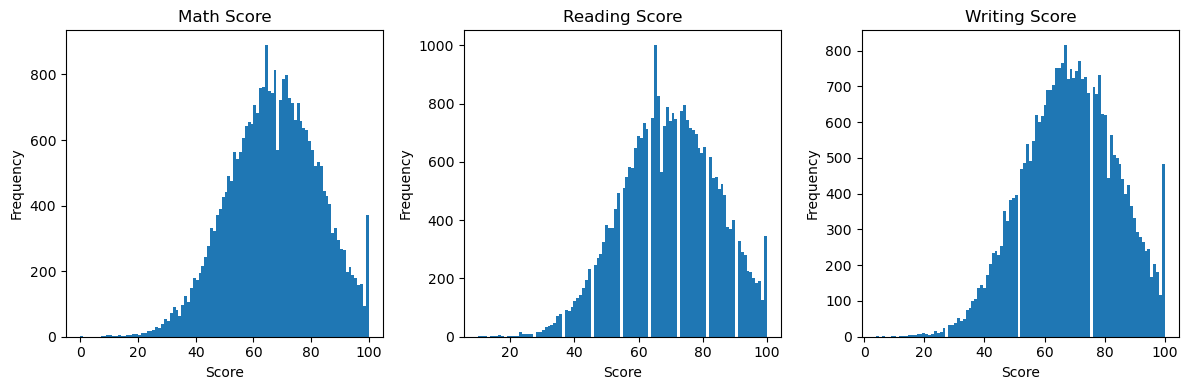

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

df_exam_score['MathScore'].plot(kind='hist', bins=100, ax=axes[0], title='Math Score')
df_exam_score['ReadingScore'].plot(kind='hist', bins=100, ax=axes[1], title='Reading Score')
df_exam_score['WritingScore'].plot(kind='hist', bins=100, ax=axes[2], title='Writing Score')

for ax in axes:
    ax.set_xlabel('Score')
    ax.set_ylabel('Frequency')

plt.tight_layout() # to avoid overlap
plt.show()

## HANDLING MISSING VALUES
FILLING WITH RANDOM FOREST

In [24]:
for column in df_exam_score.columns:
    if df_exam_score[column].isna().any():
        df_exam_score = fc.impute_missing_values_with_random_forest(df_exam_score, column)

In [25]:
df_exam_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               30641 non-null  int64  
 1   EthnicGroup          30641 non-null  object 
 2   ParentEduc           30641 non-null  float64
 3   LunchType            30641 non-null  int64  
 4   TestPrep             30641 non-null  float64
 5   ParentMaritalStatus  30641 non-null  object 
 6   PracticeSport        30641 non-null  float64
 7   IsFirstChild         30641 non-null  float64
 8   NrSiblings           30641 non-null  float64
 9   TransportMeans       30641 non-null  float64
 10  WklyStudyHours       30641 non-null  float64
 11  MathScore            30641 non-null  int64  
 12  ReadingScore         30641 non-null  int64  
 13  WritingScore         30641 non-null  int64  
dtypes: float64(7), int64(5), object(2)
memory usage: 3.3+ MB


In [26]:
df_exam_score['EthnicGroup'].unique()

array(['group D', 'group C', 'group B', 'group A', 'group E'],
      dtype=object)

In [27]:
# Applying one-hot encoding to the specified features
# Converts categorical variables into numerical representation.
# How it works: It creates new binary columns (0s and 1s) for each category in the original categorical variable.
df_exam_score = pd.get_dummies(df_exam_score, columns=['EthnicGroup', 'ParentMaritalStatus'], dummy_na=True)

df_exam_score.head().T

,0,1,2,3,4
Gender,1.00,1.00,1.00,0.00,0.00
ParentEduc,1.00,1.00,2.00,3.00,1.00
LunchType,0.00,0.00,0.00,1.00,0.00
TestPrep,0.00,1.00,0.00,0.00,0.00
PracticeSport,2.00,1.00,1.00,0.00,1.00
IsFirstChild,1.00,1.00,1.00,0.00,1.00
NrSiblings,3.00,0.00,4.00,1.00,0.00
TransportMeans,0.00,0.00,0.00,0.00,0.00
WklyStudyHours,0.00,1.00,0.00,1.00,1.00
MathScore,71.00,69.00,87.00,45.00,76.00


In [28]:
df_exam_score.drop('EthnicGroup_nan', axis=1, inplace=True)
df_exam_score.drop('ParentMaritalStatus_nan', axis=1, inplace=True)

In [29]:
df_exam_score.head().T

,0,1,2,3,4
Gender,1.00,1.00,1.00,0.00,0.00
ParentEduc,1.00,1.00,2.00,3.00,1.00
LunchType,0.00,0.00,0.00,1.00,0.00
TestPrep,0.00,1.00,0.00,0.00,0.00
PracticeSport,2.00,1.00,1.00,0.00,1.00
IsFirstChild,1.00,1.00,1.00,0.00,1.00
NrSiblings,3.00,0.00,4.00,1.00,0.00
TransportMeans,0.00,0.00,0.00,0.00,0.00
WklyStudyHours,0.00,1.00,0.00,1.00,1.00
MathScore,71.00,69.00,87.00,45.00,76.00


## normalize data 
we don't  need normalize them as we do a performance analysis and don't want to have some lose on interpretation of scores. 

In [30]:
d = preprocessing.normalize(df_exam_score)
scaled_df = pd.DataFrame(d, columns=df_exam_score.columns)
# print(scaled_df)

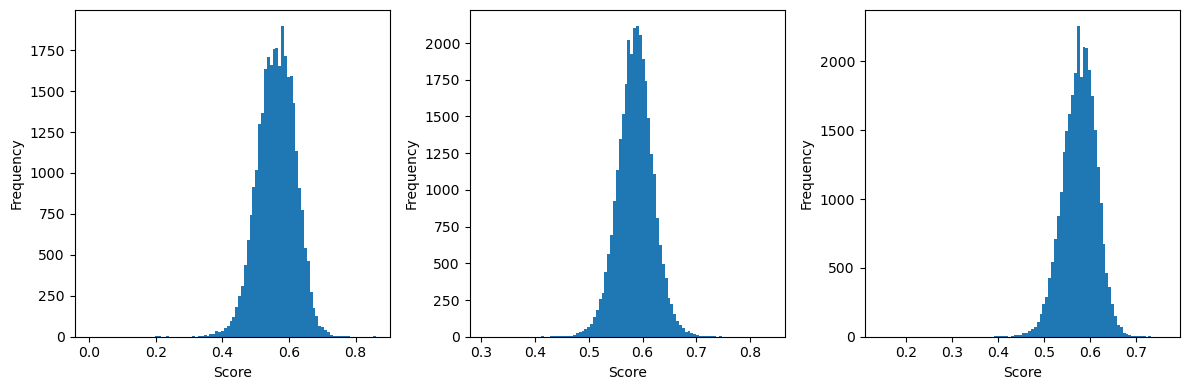

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

scaled_df['MathScore'].plot(kind='hist', bins=100, ax=axes[0])
scaled_df['ReadingScore'].plot(kind='hist', bins=100, ax=axes[1])
scaled_df['WritingScore'].plot(kind='hist', bins=100, ax=axes[2])

for ax in axes:
    ax.set_xlabel('Score')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [32]:
def generate_masks(df, column_name):
    equal_to_max_mask = df[column_name] == df[column_name].max()
    different_from_max_mask = ~equal_to_max_mask
    return equal_to_max_mask, different_from_max_mask

# Generate masks for MathScore
equal_to_max_mask_math, different_from_max_mask_math = generate_masks(df_exam_score, 'MathScore')

# Generate masks for ReadingScore
equal_to_max_mask_reading, different_from_max_mask_reading = generate_masks(df_exam_score, 'ReadingScore')

# Generate masks for WritingScore
equal_to_max_mask_writing, different_from_max_mask_writing = generate_masks(df_exam_score, 'WritingScore')


In [33]:
df_exam_score.MathScore.max()

100

In [34]:
df_exam_score_clean = df_exam_score[different_from_max_mask_math]
df_exam_score_clean = df_exam_score[different_from_max_mask_reading]
df_exam_score_clean = df_exam_score[different_from_max_mask_writing]
df_exam_score_clean

,Gender,ParentEduc,LunchType,TestPrep,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,...,WritingScore,EthnicGroup_group A,EthnicGroup_group B,EthnicGroup_group C,EthnicGroup_group D,EthnicGroup_group E,ParentMaritalStatus_divorced,ParentMaritalStatus_married,ParentMaritalStatus_single,ParentMaritalStatus_widowed
0,1,1.00,0,0.00,2.00,1.00,3.00,0.00,0.00,71,...,74,0,0,0,1,0,0,1,0,0
1,1,1.00,0,1.00,1.00,1.00,0.00,0.00,1.00,69,...,88,0,0,1,0,0,0,1,0,0
2,1,2.00,0,0.00,1.00,1.00,4.00,0.00,0.00,87,...,91,0,1,0,0,0,0,0,1,0
3,0,3.00,1,0.00,0.00,0.00,1.00,0.00,1.00,45,...,42,1,0,0,0,0,0,1,0,0
4,0,1.00,0,0.00,1.00,1.00,0.00,0.00,1.00,76,...,75,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30636,1,0.00,0,0.00,1.00,0.00,2.00,0.00,1.00,59,...,65,0,0,0,1,0,0,0,1,0
30637,0,0.00,0,0.00,2.00,0.00,1.00,1.00,1.00,58,...,51,0,0,0,0,1,0,0,1,0
30638,1,0.00,1,1.00,1.00,0.00,1.00,1.00,1.00,61,...,67,0,0,1,0,0,0,1,0,0
30639,1,3.00,0,1.00,2.00,0.00,3.00,0.00,1.00,82,...,93,0,0,0,1,0,0,1,0,0


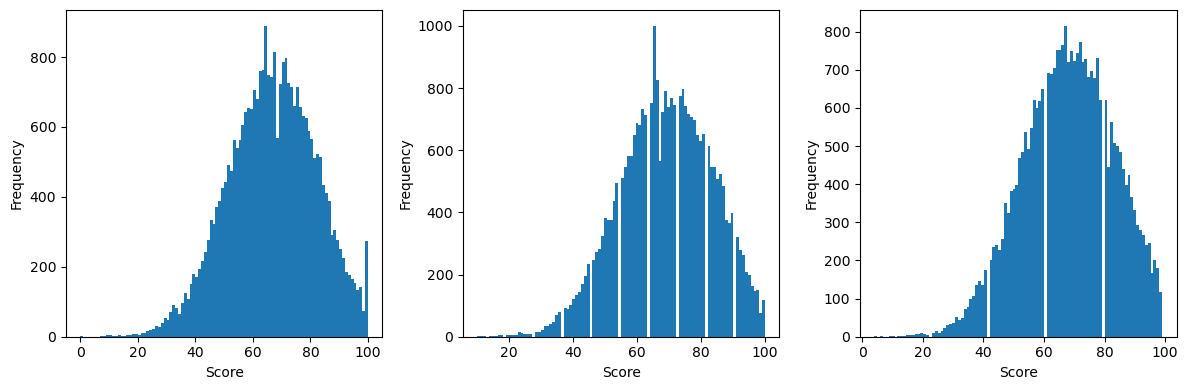

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

df_exam_score_clean['MathScore'].plot(kind='hist', bins=100, ax=axes[0])
df_exam_score_clean['ReadingScore'].plot(kind='hist', bins=100, ax=axes[1])
df_exam_score_clean['WritingScore'].plot(kind='hist', bins=100, ax=axes[2])

for ax in axes:
    ax.set_xlabel('Score')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## CORRELATION:
I transformed string values into numerical in order to have a new dataframe that I can use to see all correations.
<br> Deleted the first column because it was used  as index but we don't needed as we use pandas dataframe 

In [36]:
df_exam_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Gender                        30641 non-null  int64  
 1   ParentEduc                    30641 non-null  float64
 2   LunchType                     30641 non-null  int64  
 3   TestPrep                      30641 non-null  float64
 4   PracticeSport                 30641 non-null  float64
 5   IsFirstChild                  30641 non-null  float64
 6   NrSiblings                    30641 non-null  float64
 7   TransportMeans                30641 non-null  float64
 8   WklyStudyHours                30641 non-null  float64
 9   MathScore                     30641 non-null  int64  
 10  ReadingScore                  30641 non-null  int64  
 11  WritingScore                  30641 non-null  int64  
 12  EthnicGroup_group A           30641 non-null  uint8  
 13  E

In [37]:
df_exam_score.WklyStudyHours.unique()

array([0., 1., 2.])

In [38]:
df_exam_score.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,"30,641.00",0.50,0.50,0.00,0.00,1.00,1.00,1.00
ParentEduc,"30,641.00",1.06,1.10,0.00,0.00,1.00,2.00,3.00
LunchType,"30,641.00",0.35,0.48,0.00,0.00,0.00,1.00,1.00
TestPrep,"30,641.00",0.34,0.47,0.00,0.00,0.00,1.00,1.00
PracticeSport,"30,641.00",1.23,0.66,0.00,1.00,1.00,2.00,2.00
IsFirstChild,"30,641.00",0.65,0.48,0.00,0.00,1.00,1.00,1.00
NrSiblings,"30,641.00",2.13,1.45,0.00,1.00,2.00,3.00,7.00
TransportMeans,"30,641.00",0.40,0.49,0.00,0.00,0.00,1.00,1.00
WklyStudyHours,"30,641.00",0.90,0.66,0.00,0.00,1.00,1.00,2.00
MathScore,"30,641.00",66.56,15.36,0.00,56.00,67.00,78.00,100.00


In [39]:
df_exam_score_corr = df_exam_score.corr()

In [40]:
df_exam_score_corr

,Gender,ParentEduc,LunchType,TestPrep,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,...,WritingScore,EthnicGroup_group A,EthnicGroup_group B,EthnicGroup_group C,EthnicGroup_group D,EthnicGroup_group E,ParentMaritalStatus_divorced,ParentMaritalStatus_married,ParentMaritalStatus_single,ParentMaritalStatus_widowed
Gender,1.00,-0.00,-0.00,0.01,0.00,-0.01,0.00,0.01,0.00,-0.16,...,0.29,0.00,0.00,-0.01,-0.00,0.00,0.02,-0.02,0.01,-0.01
ParentEduc,-0.00,1.00,0.01,0.01,0.00,-0.00,-0.00,-0.00,0.00,0.14,...,0.17,-0.01,-0.00,-0.00,0.01,0.00,-0.01,0.00,0.01,-0.00
LunchType,-0.00,0.01,1.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.37,...,-0.27,-0.01,0.01,-0.00,-0.00,0.00,-0.00,-0.01,0.01,0.01
TestPrep,0.01,0.01,0.00,1.00,-0.00,-0.00,-0.01,0.01,-0.00,0.14,...,0.30,-0.01,0.01,-0.00,0.01,-0.01,0.00,-0.00,-0.00,-0.00
PracticeSport,0.00,0.00,0.00,-0.00,1.00,0.01,-0.01,-0.01,-0.00,0.08,...,0.07,-0.00,-0.01,0.00,-0.00,0.01,0.00,0.00,-0.00,-0.01
IsFirstChild,-0.01,-0.00,-0.00,-0.00,0.01,1.00,-0.12,0.00,-0.00,0.02,...,0.01,-0.01,0.01,-0.01,0.00,0.00,0.00,0.01,-0.01,0.01
NrSiblings,0.00,-0.00,-0.00,-0.01,-0.01,-0.12,1.00,0.01,0.00,-0.00,...,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.01,-0.00,-0.00,-0.00
TransportMeans,0.01,-0.00,-0.00,0.01,-0.01,0.00,0.01,1.00,0.01,-0.01,...,0.00,0.01,-0.00,0.01,-0.01,-0.01,-0.01,0.01,-0.00,-0.00
WklyStudyHours,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.01,1.00,0.09,...,0.06,0.01,-0.01,-0.01,0.01,0.01,-0.00,0.00,0.00,-0.00
MathScore,-0.16,0.14,-0.37,0.14,0.08,0.02,-0.00,-0.01,0.09,1.00,...,0.81,-0.07,-0.10,-0.08,0.04,0.23,0.00,0.01,-0.01,0.01


<AxesSubplot:>

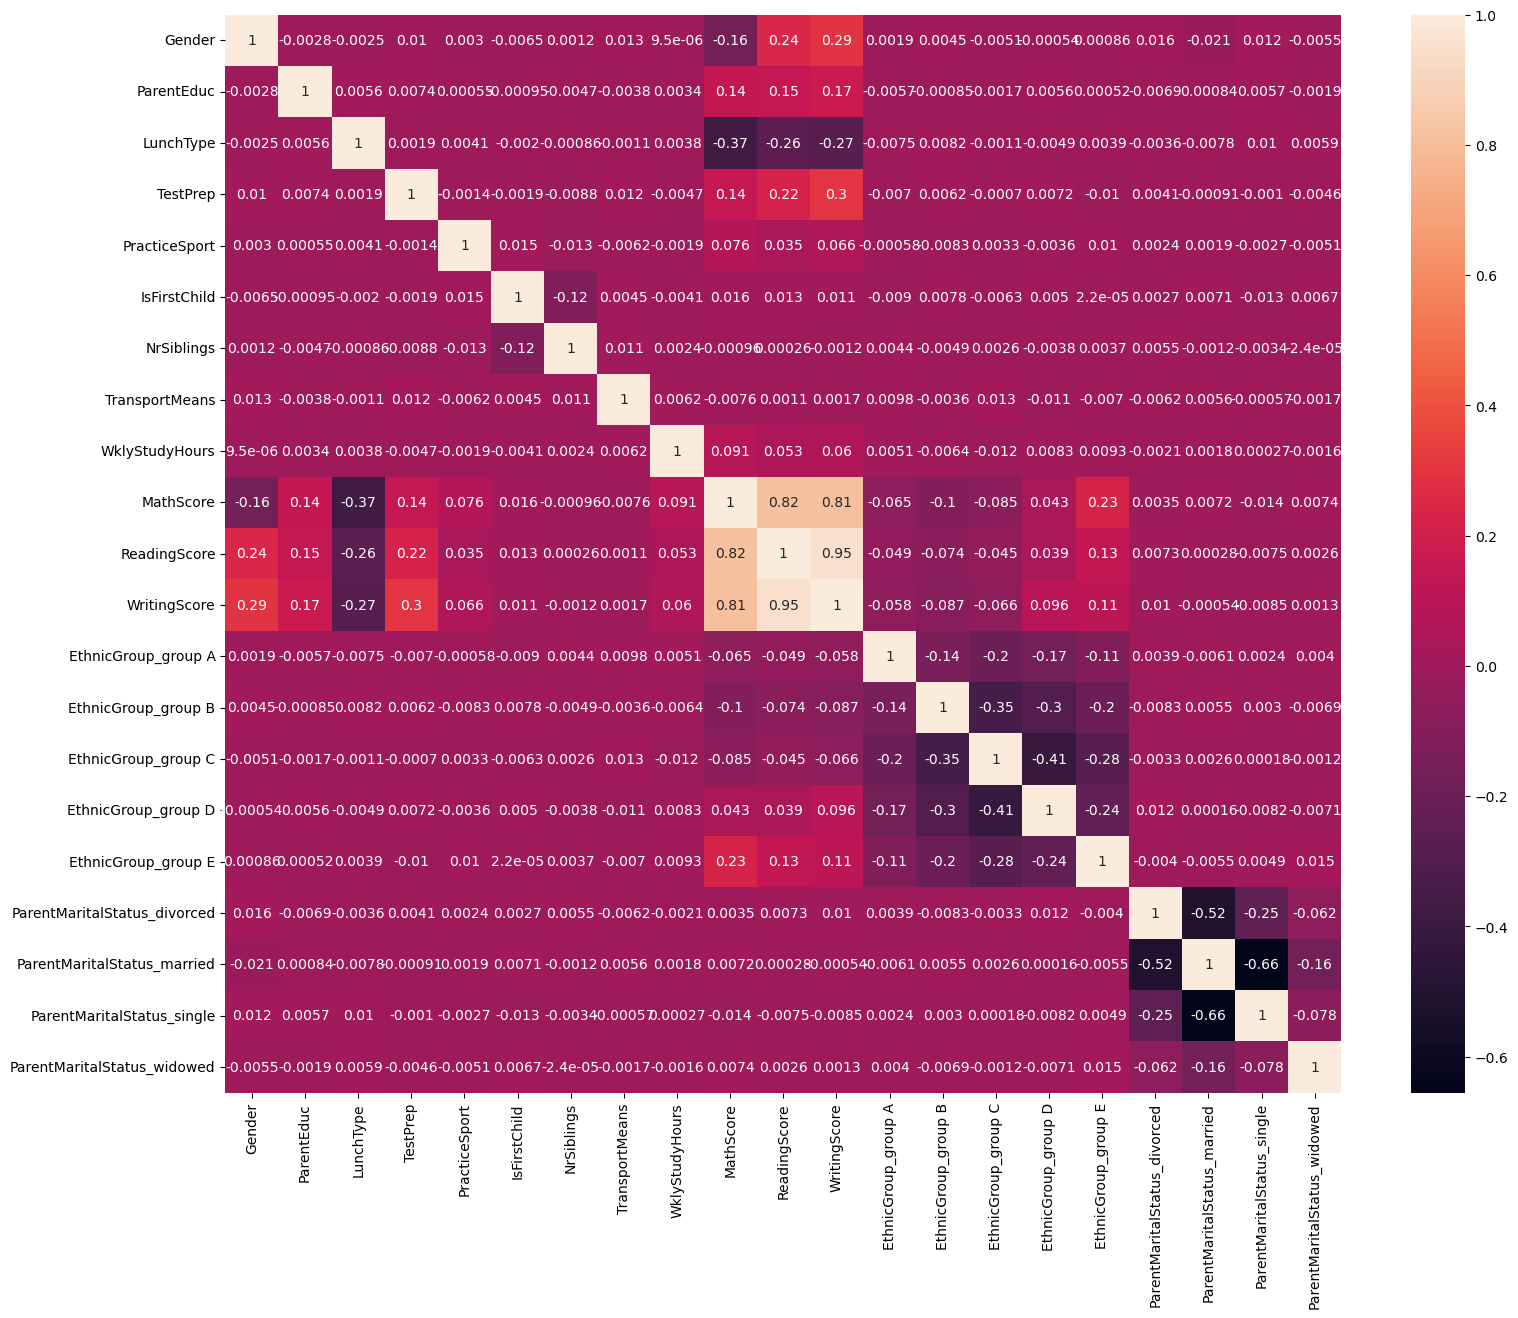

In [41]:
plt.figure(figsize=(18, 14))
sns.heatmap(df_exam_score_corr, annot=True)

# MODEL

In [42]:
df_exam_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Gender                        30641 non-null  int64  
 1   ParentEduc                    30641 non-null  float64
 2   LunchType                     30641 non-null  int64  
 3   TestPrep                      30641 non-null  float64
 4   PracticeSport                 30641 non-null  float64
 5   IsFirstChild                  30641 non-null  float64
 6   NrSiblings                    30641 non-null  float64
 7   TransportMeans                30641 non-null  float64
 8   WklyStudyHours                30641 non-null  float64
 9   MathScore                     30641 non-null  int64  
 10  ReadingScore                  30641 non-null  int64  
 11  WritingScore                  30641 non-null  int64  
 12  EthnicGroup_group A           30641 non-null  uint8  
 13  E

plotting to see if there are any outliers

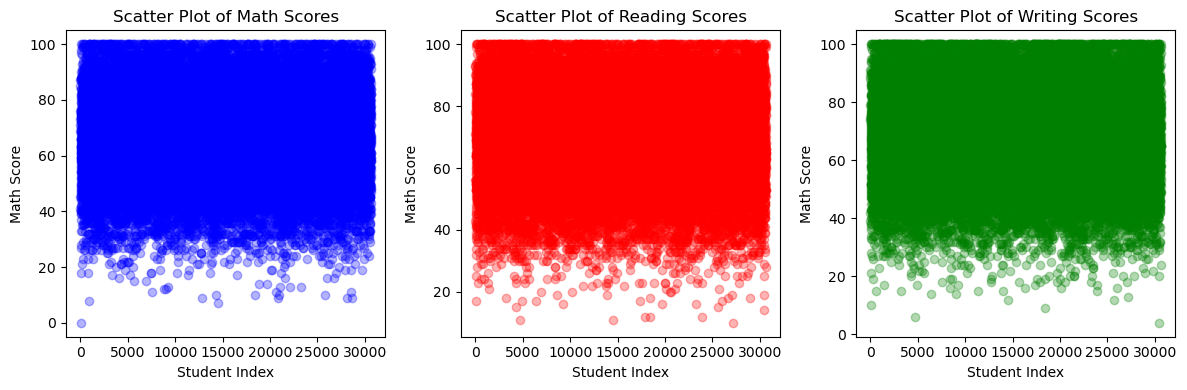

In [43]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(df_exam_score.index, df_exam_score['MathScore'], color='blue', alpha=0.3) 
plt.title('Scatter Plot of Math Scores')  
plt.xlabel('Student Index')
plt.ylabel('Math Score')

plt.subplot(1, 3, 2)
plt.scatter(df_exam_score.index, df_exam_score['ReadingScore'], color='red', alpha=0.3) 
plt.title('Scatter Plot of Reading Scores')  
plt.xlabel('Student Index')
plt.ylabel('Math Score')

plt.subplot(1, 3, 3)
plt.scatter(df_exam_score.index, df_exam_score['WritingScore'], color='green', alpha=0.3) 
plt.title('Scatter Plot of Writing Scores')  
plt.xlabel('Student Index')
plt.ylabel('Math Score')

plt.tight_layout()
plt.show()


another way to visualize the score distributions and see if there are any outilers

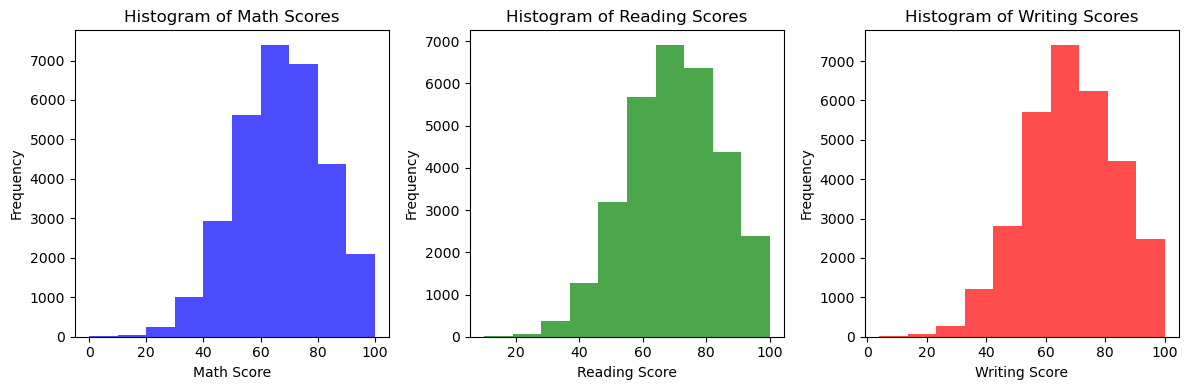

In [44]:
plt.figure(figsize=(12, 4))

# MathScore histogram
plt.subplot(1, 3, 1)
plt.hist(df_exam_score['MathScore'], bins=10, color='blue', alpha=0.7)
plt.xlabel('Math Score')
plt.ylabel('Frequency')
plt.title('Histogram of Math Scores')

# ReadingScore histogram
plt.subplot(1, 3, 2)
plt.hist(df_exam_score['ReadingScore'], bins=10, color='green', alpha=0.7)
plt.xlabel('Reading Score')
plt.ylabel('Frequency')
plt.title('Histogram of Reading Scores')

# WritingScore histogram
plt.subplot(1, 3, 3)
plt.hist(df_exam_score['WritingScore'], bins=10, color='red', alpha=0.7)
plt.xlabel('Writing Score')
plt.ylabel('Frequency')
plt.title('Histogram of Writing Scores')

plt.tight_layout()
plt.show()


visualizing outliers using boxplot, which visualize distributions 

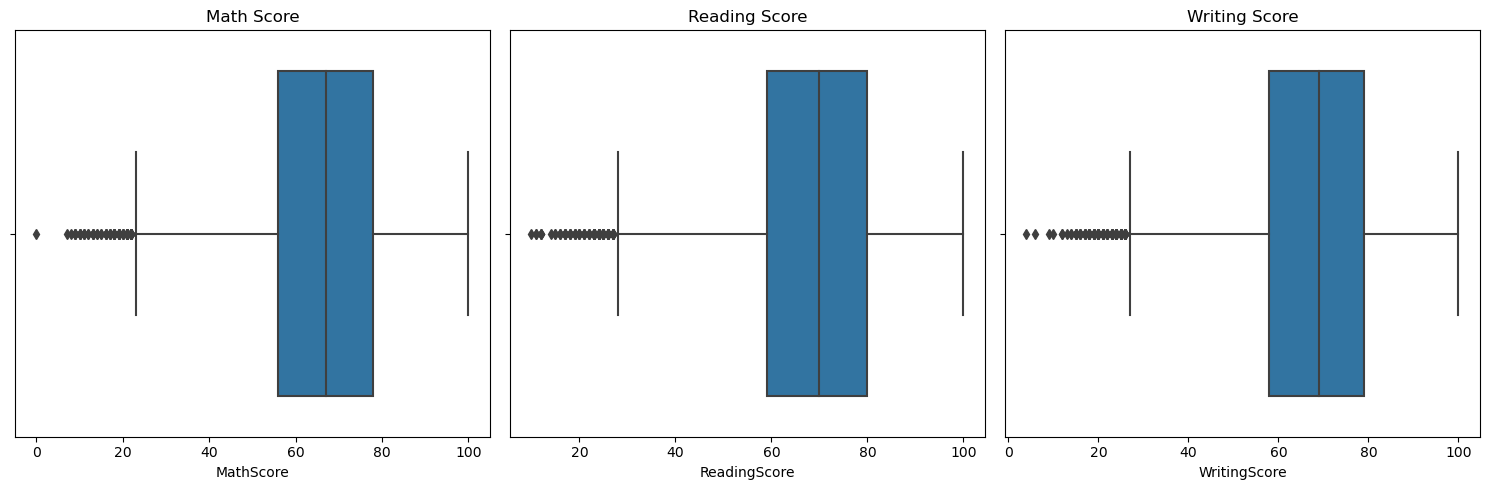

In [45]:
# Create a figure and axes for subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot MathScore boxplot
sns.boxplot(x=df_exam_score['MathScore'], ax=axs[0])
axs[0].set_title('Math Score')

# Plot ReadingScore boxplot
sns.boxplot(x=df_exam_score['ReadingScore'], ax=axs[1])
axs[1].set_title('Reading Score')

# Plot WritingScore boxplot
sns.boxplot(x=df_exam_score['WritingScore'], ax=axs[2])
axs[2].set_title('Writing Score')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


Detect outliers using z-score which is used to figure out how far each score is from the avarage score. 
<br> treshold=3 because it corresponds to approximately 99.7% of the data falling within ±3 standard deviations from the mean in a normal distribution.
<br>The numpy.where() function returns the indices of elements in an input array where the given condition is satisfied, in this case it returns zscores > 3 which are the outliers.

In [46]:
z_scores = np.abs(stats.zscore(df_exam_score[['MathScore', 'ReadingScore', 'WritingScore']]))
threshold = 3
outliers = np.where(z_scores > threshold)

# Print the indices of outliers
print("Indices of outliers:", outliers)

Indices of outliers: (array([   17,    55,    55,    55,    69,    69,   308,   308,   565,
         565,   751,   928,   928,  1344,  1484,  1484,  3197,  3197,
        3283,  3738,  4052,  4083,  4232,  4232,  4245,  4245,  4260,
        4719,  4719,  4719,  4886,  4886,  5174,  5174,  5263,  5263,
        5445,  5513,  5641,  5641,  5703,  6408,  6408,  6892,  6892,
        7423,  7440,  7553,  7553,  7553,  8373,  8373,  8428,  8439,
        8459,  8559,  8559,  8785,  9046,  9046,  9046,  9268,  9268,
        9268, 10164, 10164, 10164, 11333, 11333, 11333, 11446, 12346,
       12731, 12748, 12789, 12789, 12789, 13621, 13821, 13821, 13822,
       13846, 13933, 13933, 13980, 14274, 14494, 14494, 14494, 14708,
       14708, 15653, 15653, 16326, 16480, 17238, 17399, 17399, 17540,
       17540, 17924, 17924, 18385, 18385, 18385, 18432, 18432, 18862,
       18862, 18862, 19630, 19630, 19688, 19688, 19998, 20009, 20009,
       20127, 20127, 20127, 20249, 20554, 20554, 20603, 20603, 20860

**OUTLIER CLEANING:** not sure to do this, because they are not "problematic" values or incorrectly entered in our dataset. So, we'll see if keep the new df or not

In [47]:
# Remove outliers
df_exam_score_without_outliers = df_exam_score[(z_scores < threshold).all(axis=1)]


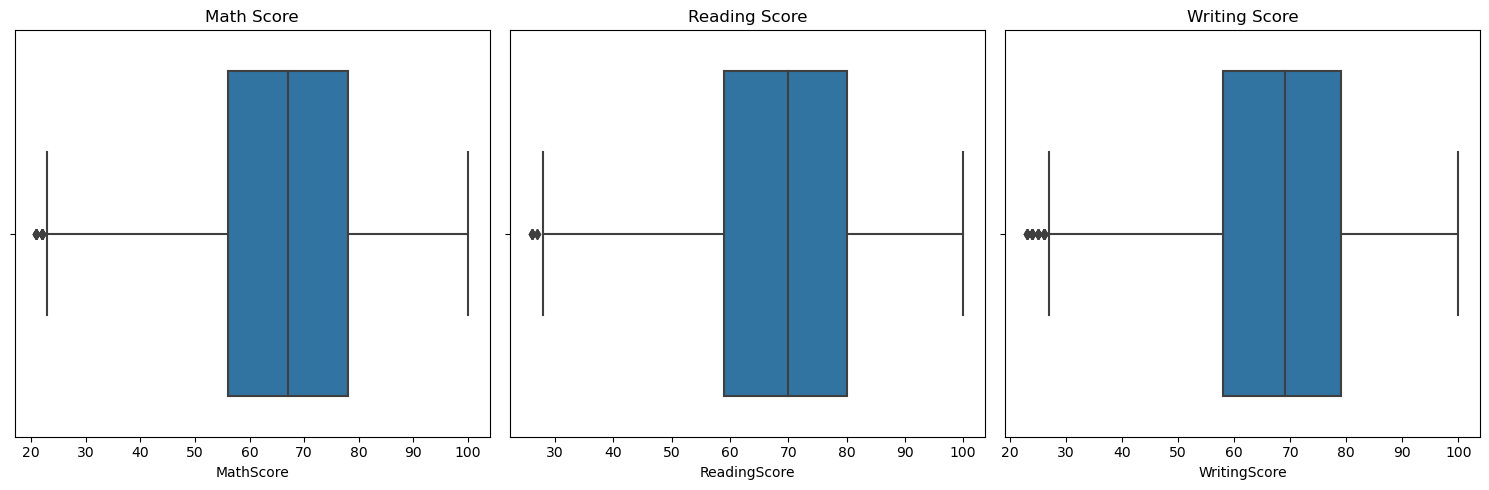

In [48]:
# Create a figure and axes for subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot MathScore boxplot
sns.boxplot(x=df_exam_score_without_outliers['MathScore'], ax=axs[0])
axs[0].set_title('Math Score')

# Plot ReadingScore boxplot
sns.boxplot(x=df_exam_score_without_outliers['ReadingScore'], ax=axs[1])
axs[1].set_title('Reading Score')

# Plot WritingScore boxplot
sns.boxplot(x=df_exam_score_without_outliers['WritingScore'], ax=axs[2])
axs[2].set_title('Writing Score')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## BUILDING MODEL

In [49]:
X = df_exam_score.drop(['MathScore','ReadingScore','WritingScore'], axis=1)
y_math=df_exam_score['MathScore']
y_read=df_exam_score['ReadingScore']
y_write=df_exam_score['WritingScore']

Preparation for model training and evaluation:

In [68]:
def model_evaluation(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    MAE = metrics.mean_absolute_error(y_test, y_pred)
    print(f'MAE score is: {MAE}')
    MSE = metrics.mean_squared_error(y_test, y_pred)
    print(f'MSE score is: {MSE}')
    RMSE = np.sqrt(MSE)
    print(f'RMSE score is: {RMSE}')
    R2_Score = metrics.r2_score(y_test, y_pred)
    print(f'R2_Score score is: {R2_Score}')
    
    return pd.DataFrame([MAE, MSE, RMSE, R2_Score], index=['MAE', 'MSE', 'RMSE' ,'R2-Score'], columns=[model_name])



def model_train(X,y,model):
    #split dataset by taking 80% of data for training and 20% of data for testing.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    model.fit(X_train, y_train)

    model_evaluation(model, X_test, y_test, 'Linear Reg.')
    
    return model

First trial:LinearRegressor on Math Score

In [69]:
model=LinearRegression()
model_math=model_train(X,y_math,model)

MAE score is: 10.538205052331879
MSE score is: 169.2170855112697
RMSE score is: 13.008346763185154
R2_Score score is: 0.2821964284922207


Second Trial: PolyRegressor of degree 2 on Math Score

In [70]:
# Create polynomial features
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

# Create and fit the polynomial regression model
model = LinearRegression()
model_math=model_train(X_poly,y_math,model)

MAE score is: 10.476459524957871
MSE score is: 167.51356389309774
RMSE score is: 12.942703113843635
R2_Score score is: 0.2894226131175498


In [71]:
# Create polynomial features
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_features.fit_transform(X)

# Create and fit the polynomial regression model
model = LinearRegression()
model_math=model_train(X_poly,y_math,model)

MAE score is: 10.572917437666217
MSE score is: 171.12734242119566
RMSE score is: 13.08156498363998
R2_Score score is: 0.27409329145792305


Since scores slightly drop with degree increase, degree of 2 is accepted sufficient

Fourth Trial: Random Forest Regression on Math Score

In [72]:
model=RandomForestRegressor(n_estimators=100)
model_math=model_train(X,y_math,model)

MAE score is: 11.732384028751968
MSE score is: 214.12848916554148
RMSE score is: 14.633129848584733
R2_Score score is: 0.09168631630667046


Fifth Trial: XGBoost

In [73]:
model = XGBRegressor(learning_rate=0.05,max_depth=2,n_estimators= 150)
model_math=model_train(X,y_read,model)

MAE score is: 10.542120935555518
MSE score is: 168.64830718620186
RMSE score is: 12.986466308669263
R2_Score score is: 0.22005246560145442


Decision: From trials, highest score is on Polynomial regression with 2 degrees

In [74]:
# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Create and fit the polynomial regression model
model = LinearRegression()
print('Math Model Evaluation')
model_math=model_train(X_poly,y_math,model)
print('Reading Model Evaluation')
model_read=model_train(X_poly,y_read,model)
print('writing Model Evaluation')
model_write=model_train(X_poly,y_write,model)

Math Model Evaluation
MAE score is: 10.476459524957871
MSE score is: 167.51356389309774
RMSE score is: 12.942703113843635
R2_Score score is: 0.2894226131175498
Reading Model Evaluation
MAE score is: 10.539442563099735
MSE score is: 168.91656465208297
RMSE score is: 12.996790551981784
R2_Score score is: 0.21881185576321305
writing Model Evaluation
MAE score is: 10.272621128644303
MSE score is: 160.26748187506942
RMSE score is: 12.65967937489214
R2_Score score is: 0.32100074826312663


as i don't want to work for each subject separetely i will create a new column called GradePointAvarage which is contain average of grade point of each student and i'll work on that